In [195]:
'''
Stellar Evolution Predictor
(Using Mass, Metallicity, and Monte Carlo Uncertainty)

This notebook predict's a star's final evolutionary remnant using astrophysical approximations:

Inputs (from user):
- initial mass in solar masses
- metallicity (Z)

Outputs:
- Main-sequence lifetime
- Effective final mass (M_eff) after mass loss
- Remnant classification
- Monte Carlo probability distribution of final outcomes
- Mass loss distribution (Bar chart)
- Nucleosynthetic yield visualization (Bar chart)

'''

"\nStellar Evolution Predictor\n(Using Mass, Metallicity, and Monte Carlo Uncertainty)\n\nThis notebook predict's a star's final evolutionary remnant using astrophysical approximations:\n\nInputs (from user):\n- initial mass in solar masses\n- metallicity (Z)\n\nOutputs:\n- Main-sequence lifetime\n- Effective final mass (M_eff) after mass loss\n- Remnant classification\n- Monte Carlo probability distribution of final outcomes\n- Mass loss distribution (Bar chart)\n- Nucleosynthetic yield visualization (Bar chart)\n\n"

In [196]:
import numpy as np, matplotlib.pyplot as plt
from collections import Counter
import re
import pandas as pd
from io import StringIO
import glob
import os

In [197]:
# PARSE ISOTOPE YIELD FILES
def parse_yield_file(path):
    ''' parse files with structure:
    H Table: (M=1.0,Z=0.01)
    ...
    Isotopes Yields ... ...
    H-1 ...
    H-2 ...
    Returns: mass, df with isotopes + yields

    fix: finds mass from file name instead
    read online lines that start with Element-Number
    takes the LAST numerical entry to avoid duplicates
    skips malformed/wrapped lines
    '''

    # read file
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # extract mass from filename
    mass = None
    for line in lines:
        if "M=" in line:
            text = line.strip()
            left = text.find("M=") + 2
            right = left
            while right < len(text) and (text[right].isdigit() or text[right] in ".+-eE"):
                right += 1
            mass = float(text[left:right])
            break

    
    isotopes, yields = [], []

    with open(path, errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            
            line_parts = line.split()
            isotp_name = line_parts[0]

            if "-" not in isotp_name:
                continue

            y = float(line_parts[1]) #yield will always be second entry no matter the format

            
            isotopes.append(isotp_name)
            yields.append(y)

    df = pd.DataFrame({"Isotopes": isotopes, "Yields": yields})
    df = df.drop_duplicates(subset="Isotopes", keep="first")

    return mass, df


In [198]:
# LOOP TO PARSE ALL FILES

def make_yield_grid(folder):
    dfs, masses = [], []

    for fname in os.listdir(folder):
        if not fname.endswith(".txt"):
            continue
        path = os.path.join(folder, fname)

        mass, df = parse_yield_file(path)
        colname = f"M{mass}"

        df = df.rename(columns={"Yields" : colname})

        dfs.append(df)
        masses.append(mass)

    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.merge(df, on="Isotopes", how="outer")

    combined_df = combined_df.set_index("Isotopes")

    col_order = sorted(combined_df.columns, key=lambda x: float(x[1:]))
    combined_df = combined_df[col_order]

    return combined_df



In [199]:
# YIELDS FROM METALLICITY DATAFRAMES

#replace paths with own path

df_Z00001 = make_yield_grid("../final_project/yield_data/Z00001")
df_Z00002 = make_yield_grid("../final_project/yield_data/Z00002")
df_Z0001 = make_yield_grid("../final_project/yield_data/Z0001")
df_Z0006 = make_yield_grid("../final_project/yield_data/Z0006")
df_Z001 = make_yield_grid("../final_project/yield_data/Z001")
df_Z002 = make_yield_grid("../final_project/yield_data/Z002")
df_Z003 = make_yield_grid("../final_project/yield_data/Z003")

# df_Z0001, df_Z00002, df_Z0001, df_Z0006, df_Z001, df_Z002, df_Z003



In [200]:
#INPUT

In [201]:
#MAIN SEQUENCE LIFETIME

In [202]:
#MASS LOSS FUNCTION FROM METALLICITY Z

In [203]:
# ISOTOPE YIELD INTERPOLATION

'''
For a singular isotope, build a 2d (Z x M) grid
        M1.0        M2.0        ...
Z
0.00001
0.00002
0.001
...

and use this grid to interpolate yield for a specific isotope for any (M, Z)

then, loop through all isotopes to produce a full predicted-yield df
        Yield
Isotopes
H-1        ...
H-2       ...
'''

# combine all metallicites into one dict
yield_grids = {
    0.00001: df_Z00001,
    0.00002: df_Z00002,
    0.0001: df_Z0001,
    0.0006: df_Z0006,
    0.001: df_Z001,
    0.002: df_Z002,
    0.003: df_Z003
}

# get ZxM grid
def isotope_grid(isotope, yield_grids):
    '''
    construct a 2d grid df representing the yields of a SINGLE isotope as a function of Z and M

    parameters:
    isotope: str, isotope name
    yield_grids: dictionary 
    
    returns df with:
    index = Z vals
    cols = sorted mass vals
    vals = yields for the isotope

    '''
    
    Z_vals = sorted(yield_grids.keys()) #sort the metallicities

    #collect all mass column names from any df
    M_cols = sorted([float(c[1:]) for c in list(yield_grids.values())[0].colume])

    grid = []
    for Z in Z_vals:
        df = yield_grids[Z]
        row = df.loc[isotope].values.astype(float) # yields for this isotope at all masses for this Z
        grid.append(row)

    grid_df = pd.DataFrame(grid, index=Z_vals, columns=M_cols)

    grid_df.index.name= "Z"
    grid_df.columns.name= "M"

    return grid_df


# interpolate yield for one isotope at M_targ, Z_targ

def interpolate_isotope(yield_grids, isotope, M_targ, Z_targ):
    ''' returns yield for one isotope at any (M_targ, Z_targ)
    stategy: 2 part interpolation
    1. interpolate along M for each Z
    2. interpolate along Z
    '''    

    Z_vals = sorted(yield_grids.keys())
    yield_atZ = []

    for Z in Z_vals:
        df = yield_grids[Z]
        masses = np.array([float(c[1:]) for c in df.columns])
        values = df.loc[isotope].values.astype(float)

        # interpolate along M for Z
        yield_M = np.interp(M_targ, masses, values)
        yield_atZ.append(yield_M)

    # interpolate along Z
    yield_atZ = np.array(yield_atZ)
    return np.interp(Z_targ, Z_vals, yield_atZ)


# interpolate yield for all isotopes at (M_targ, Z_targ)

def interpolate_all(yield_grids, M_targ, Z_targ):
    ''' returns a df with:
    index = isotopes
    column = yield

    for a set M, Z of the target
    '''

    some_Z = list(yield_grids.keys())[0] # we can get a list of isotopes with any Z table
    isotopes = yield_grids[some_Z].index

    results = []
    for isotope in isotopes:
        val = interpolate_isotope(yield_grids, isotope, M_targ, Z_targ)
        results.append(val)

    df_out = pd.DataFrame({"Yield": results}, index=isotopes)
    df_out.index.name = "Isotopes"
    return df_out



In [204]:
#testing

df_pred = interpolate_all(yield_grids, M_targ=2.4, Z_targ=0.0015)
# df_pred



In [209]:
# PLOT YIELDS BY ELEMENT

def plot_yields_by_element(df_pred):
    ''' generates grouped bar charts for each element'''

    # group isotopes by element name
    groups = {}
    for isotope in df_pred.index:
        element = isotope.split("-")[0] # "C-12" -> "C"
        groups.setdefault(element, []).append(isotope)

    # sort groups alphabetically by element
    element_list = sorted(groups.keys(), key=lambda x: (len(x), x))

    # create subplots
    num = len(element_list)
    cols = 3
    rows = int(np.ceil(num/cols))

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3), squeeze = False)
    
    #plot each element
    for idx, element in enumerate(element_list):
        ax = axes[idx // cols][idx % cols]

        isotopes = groups[element]
        vals = df_pred.loc[isotopes, "Yield"].values

        ax.bar(isotopes, vals)
        ax.set_title(f"{element} isotopes")
        ax.set_ylabel("Yield (in solar masses)")
        ax.set_xticks(range(len(isotopes)))
        ax.set_xticklabels(isotopes, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()






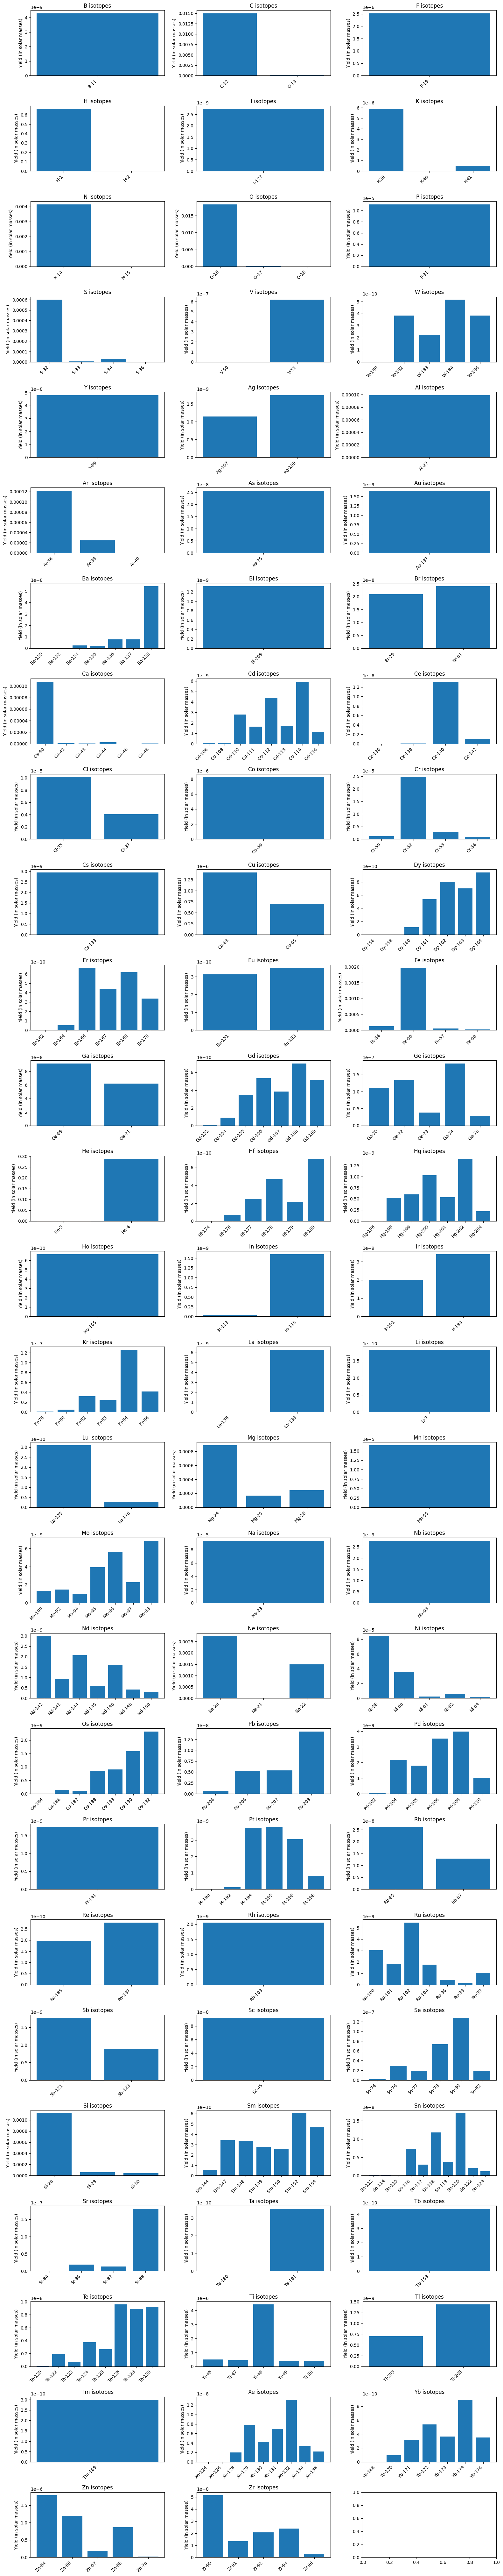

In [ ]:
# testing

df_pred = interpolate_all(yield_grids, M_targ=2.4, Z_targ=0.015)
plot_yields_by_element(df_pred)
